# Install required packages and set up environment if needed

In [1]:
import pandas as pd

from momentum_backtester.adapters.sp500_github_adapter import load_tiny_sample, load_sp500_data_wrds
from momentum_backtester.backtester import Backtester
from momentum_backtester.signals import price_momentum
from momentum_backtester.ranking import cross_sectional_rank
from momentum_backtester.aggregation import long_short_top_bottom_sector_neutral
from momentum_backtester.costs import turnover_costs
from momentum_backtester.analysis import Analysis

# Load the required data for backtesting

In [ ]:
# WRDS
# refer from another package: https://github.com/ZhengGong-hub/academic_data_download
data = load_sp500_data_wrds(start_year=2019, end_year=2022)

Loading SP500 data...
Connecting to WRDS with username: zhenggong123
Loading library list...
Done
Connected to WRDS!
Loading SP500 data for year 2019...
the number of unique permnos for year 2019 is 503
the number of unique gvkeys for year 2019 is 498
Loading SP500 data for year 2020...
the number of unique permnos for year 2020 is 504
the number of unique gvkeys for year 2020 is 499
Loading SP500 data for year 2021...
the number of unique permnos for year 2021 is 504
the number of unique gvkeys for year 2021 is 499
Loading SP500 data for year 2022...
the number of unique permnos for year 2022 is 503
the number of unique gvkeys for year 2022 is 498


In [3]:
# let's have a look at the data 
sp500_universes = data["sp500_universes"][0]
sp500_universes

SP500Universe(year=2019, gvkeys=<StringArray>
['012142', '012141', '012138', '001300', '001722', '012635', '012850',
 '003144', '013421', '003413',
 ...
 '178507', '179621', '179534', '179437', '010903', '180711', '180652',
 '004016', '183377', '184500']
Length: 498, dtype: string, permnos=<IntegerArray>
[10104, 10107, 10138, 10145, 10516, 10696, 10909, 11308, 11403, 11404,
 ...
 92602, 92611, 92614, 92655, 92778, 93002, 93089, 93096, 93132, 93429]
Length: 503, dtype: Int64)

In [4]:
# let's have a look at the data
# return df 
# we have two types of return_df:
# 1. retoto_df_wide: open-to-open return
# 2. retctc_df_wide: close-to-close return
retoto_df_wide = data["retoto_df_wide"]
retctc_df_wide = data["retctc_df_wide"]

# price df
# we have two types of price_df:
# 1. adjclose_df_wide: adjusted close price
# 2. adjopen_df_wide: adjusted open price
adjclose_df_wide = data["adjclose_df_wide"]
adjopen_df_wide = data["adjopen_df_wide"]

# sector df
sector_df_wide = data["sector_df_wide"]

# let's have a look at the data
# retoto_df_wide.tail()
# retctc_df_wide.tail()
# adjclose_df_wide.tail()
adjopen_df_wide.tail()
# sector_df_wide.tail()

permno,10104,10107,10138,10145,10516,10696,10909,11308,11403,11404,...,92614,92655,92778,93002,93089,93096,93132,93246,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,80.51,236.11,110.29,212.0,93.92,99.38,<NA>,63.5,160.92,95.08,...,152.0,524.09998,<NA>,55.0,173.52,244.32001,48.97,90.0,125.76,126.37
2022-12-27,80.88,238.7,111.13,213.89999,94.99,100.5,<NA>,63.93,161.10001,96.04,...,152.67999,533.92999,<NA>,55.154999,175.8,247.42999,48.44,92.42,127.17,117.495
2022-12-28,81.09,236.89,110.53,215.92999,95.9,100.99,<NA>,64.46,159.95,96.81,...,154.67999,535.07001,<NA>,55.164001,175.56,247.46001,48.495,93.55,124.86,110.35
2022-12-29,80.97,235.64999,109.72,213.09,93.88,100.5,<NA>,63.8,159.59,96.48,...,154.05,532.53998,<NA>,55.184998,174.61,245.64,48.1,97.24,127.59,120.385
2022-12-30,81.13,238.21001,109.6,213.98,92.37,100.69,<NA>,63.92,159.92,96.62,...,154.53,530.0,<NA>,55.182001,176.63,247.33,48.55,99.33,127.19,119.95


# Run the backtester

In [5]:
bt = Backtester(
    retoto_df_wide=retoto_df_wide,
    retctc_df_wide=retctc_df_wide,
    adjclose_df_wide=adjclose_df_wide,
    adjopen_df_wide=adjopen_df_wide,
    sector_df_wide=sector_df_wide,
    signal=lambda px: price_momentum(
        px, 
        lookback_months=11, 
        skip=1),
    ranker=cross_sectional_rank,
    aggregator=lambda ranks, sectors: long_short_top_bottom_sector_neutral(
        ranks, 
        sectors, 
        top_pctg=20, 
        bottom_pctg=20),
    costs=lambda w: turnover_costs(w, 10.0),
    rebal_freq="M",
)
results = bt.run()

In [ ]:
# peek 
results.keys()
# results

In [48]:
# quick summary
summary = {
    "start": results["net_returns"].index.min(),
    "end": results["net_returns"].index.max(),
    "n_days": int(results["net_returns"].shape[0]),
    "cum_return": float((1 + results["net_returns"]).prod() - 1.0),
}
summary

{'start': Timestamp('2019-01-02 00:00:00'),
 'end': Timestamp('2022-12-30 00:00:00'),
 'n_days': 1008,
 'cum_return': -0.27989454799859714}

# Run analysis on the backtest results


In [6]:
# load in analysis class
analysis = Analysis(output_dir="output")

In [7]:
cagr = analysis.cagr(results["net_returns"], 252, verbose=False)
print("the CAGR is: ", cagr)

the CAGR is:  -0.0788


In [8]:
vol = analysis.annual_vol(results["net_returns"], periods_per_year=252, verbose=False)
print("the annual volatility is: ", vol)

the annual volatility is:  0.1872


In [9]:
sharpe = analysis.sharpe(results["net_returns"], risk_free=0.0, periods_per_year=252, verbose=False)
print("the Sharpe ratio is: ", sharpe)

the Sharpe ratio is:  -1.3768


In [10]:
mdd = analysis.max_drawdown(results["net_returns"], verbose=False)
print("the maximum drawdown is: ", mdd)

the maximum drawdown is:  -0.4547


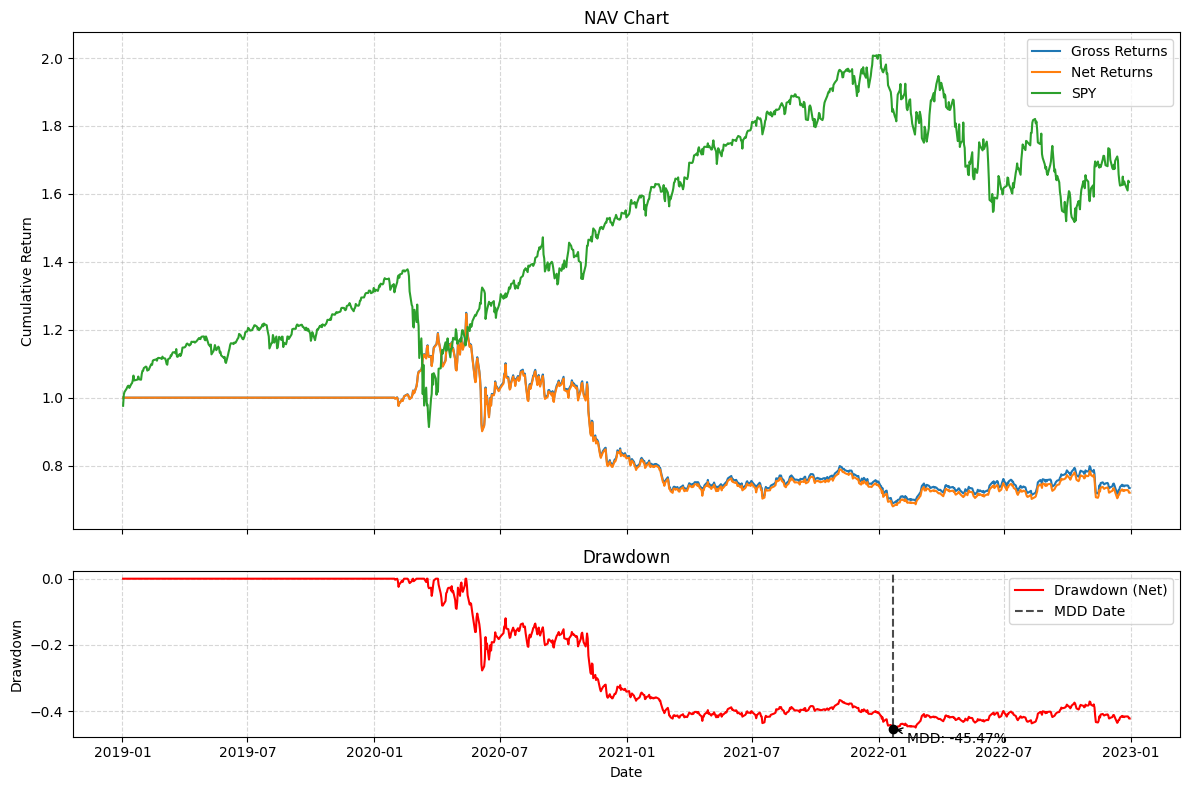

In [11]:
analysis.nav_chart(
    results["gross_returns"], 
    results["net_returns"], 
    incl_spy=True, 
    spy_daily=data["spy_daily"])

In [12]:
analysis.against_spy(results["net_returns"], data["spy_daily"], verbose=False)

{'alpha_annual': -0.0471,
 'beta': -0.1166,
 'alpha_per_period': -0.0002,
 'r2': 0.0197}

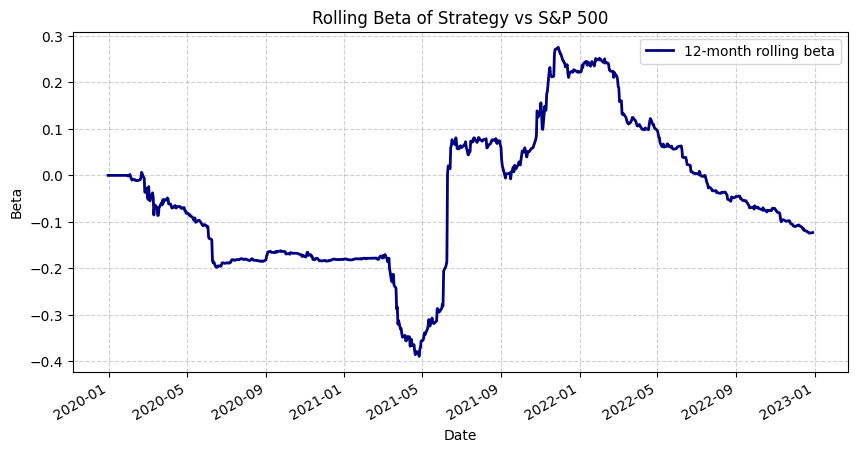

In [14]:
analysis.rolling_beta(results["net_returns"], data["spy_daily"])

In [15]:
analysis.return_attr_sector(
    results["weights"], 
    data["sector_df_wide"], 
    results["retoto_df_wide"], 
    results["gross_returns"],
    verbose=False
    )


2019-01-02 00:00:00
45            0.011392
20            -0.08618
40           -0.018429
25           -0.052267
35           -0.027372
30           -0.022395
60           -0.015686
10           -0.020746
55            -0.02309
50           -0.002331
15            0.014236
-gross_ret    0.238732
check_sum    -0.004138
dtype: object

date
2019-12-31     0.000000
2020-12-31    12.152174
2021-12-31    13.500000
2022-12-31    12.340474
Freq: YE-DEC, dtype: float64

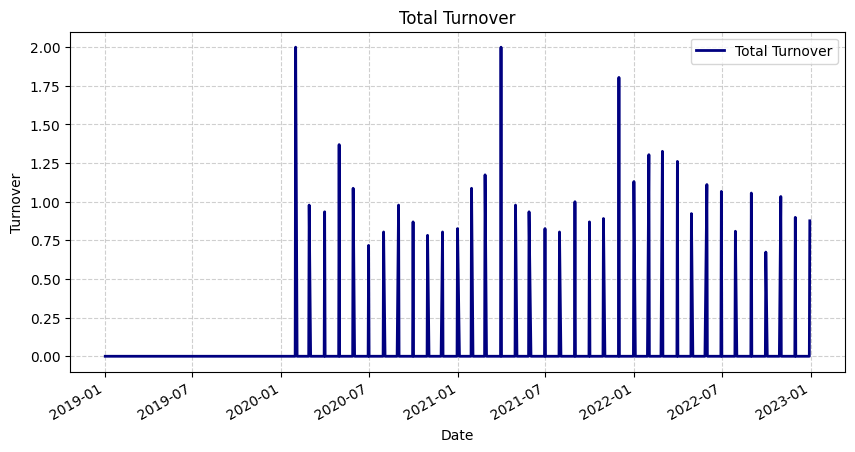

In [16]:
analysis.total_turnover(results["weights"], verbose=False)